Running Custom Cart Pole with PID controller...
PID parameters: Kp=15.0, Ki=0.1, Kd=40.0
Length of time array: 150
Length of states array: 150
Length of control signals array: 150


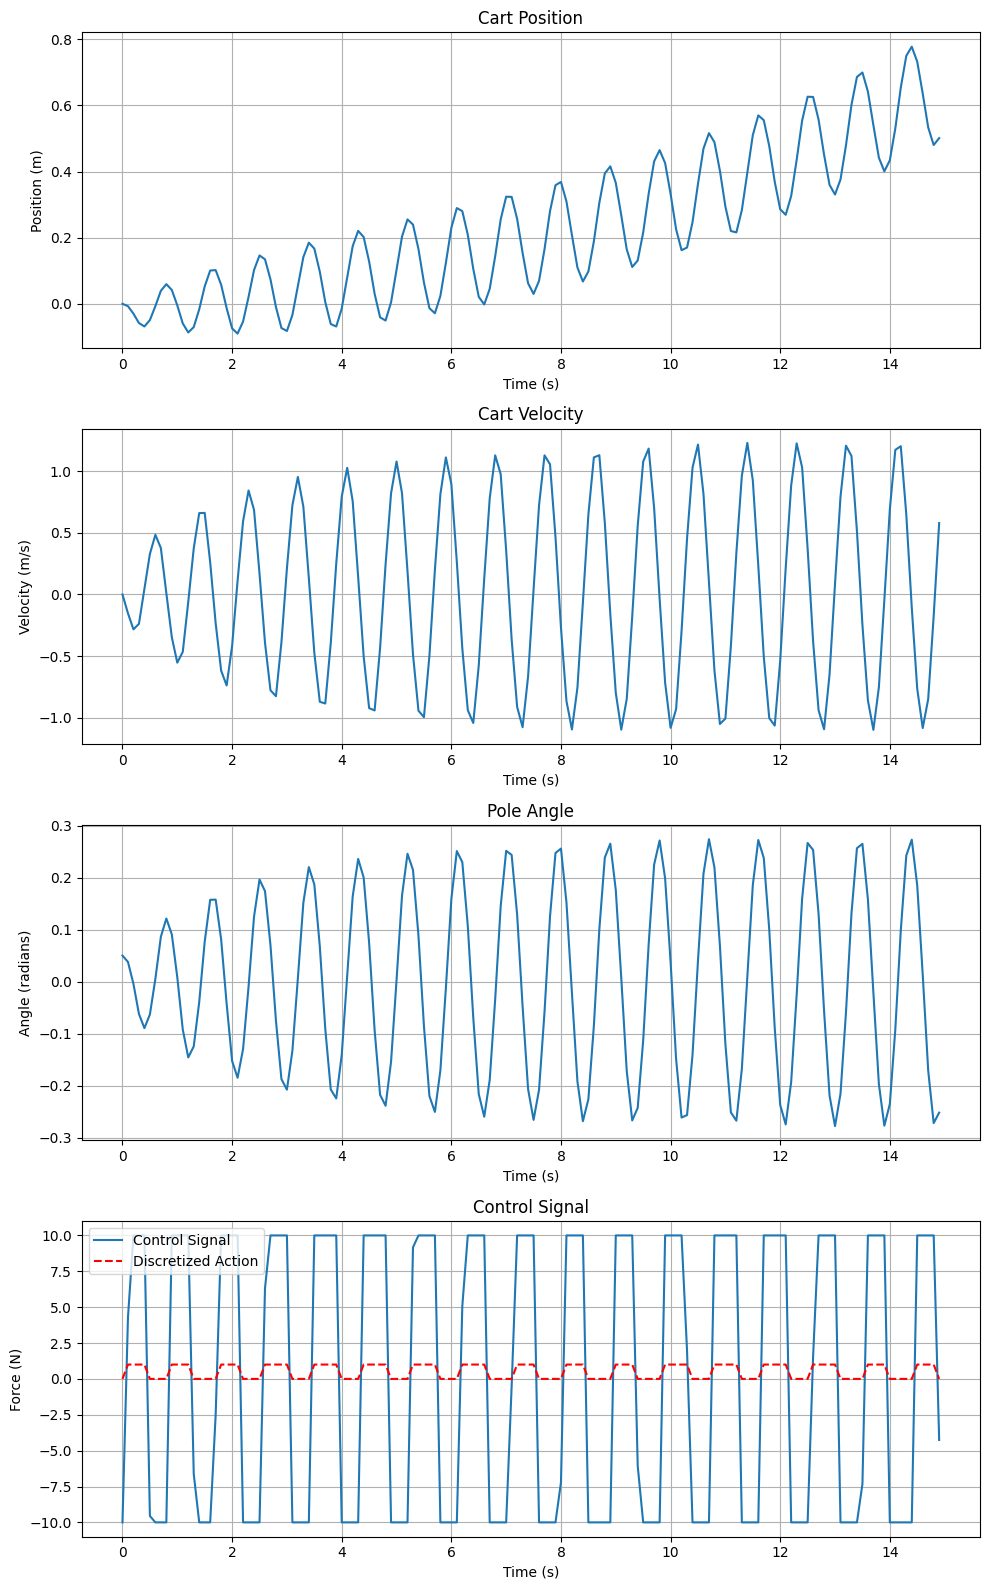

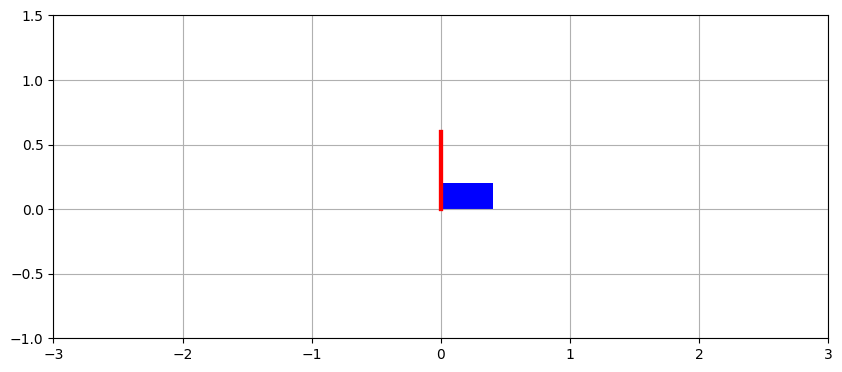

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import solve_ivp

# Physical parameters of the cart-pole system
M = 0.5    # Cart mass (kg)
m = 0.2    # Pendulum mass (kg)
b = 0.1    # Cart friction coefficient (N/m/s)
I = 0.006  # Pendulum moment of inertia (kg⋅m²)
g = 9.81   # Gravitational acceleration (m/s²)
l = 0.3    # Length to pendulum center of mass (m)
Ts = 1/10  # Sampling time (s)

# State space model matrices
A_22 = (-(I+m*l**2)*b)/(I*(M+m)+M*m*l**2)
A_23 = (m**2 * g * l**2)/ (I*(M+m) + M*m* l**2)
A_42 = (-m*l*b)/(I*(M+m) + M*m* l**2)
A_43 = ((m*g*l)*(M+m))/(I*(M+m) + M*m* l**2)
B_2 = (I + m*l**2)/(I*(M+m) + M*m*l**2)
B_4 = (m*l)/(I*(M+m) + M*m*l**2)

# State space matrices
A = np.array([
    [0, 1, 0, 0],
    [0, A_22, A_23, 0],
    [0, 0, 0, 1],
    [0, A_42, A_43, 0]
])

B = np.array([
    [0],
    [B_2],
    [0],
    [B_4]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

D = np.array([
    [0],
    [0]
])

class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp  # Proportional gain
        self.ki = ki  # Integral gain
        self.kd = kd  # Derivative gain
        self.prev_error = 0
        self.integral = 0
    
    def update(self, error, dt=Ts):  # Using the defined sampling time
        # Calculate the integral term with anti-windup
        self.integral += error * dt
        self.integral = np.clip(self.integral, -5.0, 5.0)  # Anti-windup
        
        # Calculate the derivative term
        derivative = (error - self.prev_error) / dt
        
        # Calculate the control output
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        
        # Update previous error for next iteration
        self.prev_error = error
        
        return output

def cartpole_dynamics(t, state, u):
    """
    Custom cart-pole dynamics based on the provided parameters.
    state = [x, x_dot, theta, theta_dot]
    u = control input (force applied to cart)
    """
    x, x_dot, theta, theta_dot = state
    
    # Calculate state derivatives using the state space model
    state_dot = A @ state + B @ np.array([u])
    
    return state_dot.flatten()

def run_custom_cartpole_with_pid(kp=1.0, ki=0.0, kd=0.5, max_time=10.0):
    """Run a simulation of the custom cart-pole system with a PID controller."""
    # Initialize PID controller
    pid = PIDController(kp, ki, kd)
    
    # Initial state: [x, x_dot, theta, theta_dot]
    # Starting with a small angle to make it interesting
    initial_state = np.array([0.0, 0.0, 0.05, 0.0])
    
    # Time points
    t_span = (0, max_time)
    t_eval = np.arange(0, max_time, Ts)
    
    # Lists to store results
    control_signals = []
    
    # Function for the ODE solver that incorporates the PID controller
    def system_with_control(t, state):
        # Extract pole angle from state
        theta = state[2]
        
        # Calculate error (we want theta = 0, upright position)
        error = -theta  # Negative because we want to counteract the angle
        
        # Get control signal from PID
        control_signal = pid.update(error, Ts)
        
        # Limit the control force (optional)
        control_signal = np.clip(control_signal, -10, 10)
        
        # Return the system dynamics
        return cartpole_dynamics(t, state, control_signal)
    
    # Solve the ODE
    solution = solve_ivp(
        system_with_control,
        t_span,
        initial_state,
        method='RK45',
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    
    # Calculate control signals for each time point after the simulation
    times = solution.t
    states = solution.y
    control_signals = []
    actions = []
    
    # Reset PID controller for consistent calculation
    pid = PIDController(kp, ki, kd)
    
    for i in range(len(times)):
        theta = states[2, i]
        error = -theta
        control_signal = pid.update(error, Ts)
        control_signal = np.clip(control_signal, -10, 10)
        control_signals.append(control_signal)
        actions.append(1 if control_signal > 0 else 0)
    
    return times, states, np.array(control_signals), np.array(actions)

def visualize_custom_simulation(times, states, control_signals, actions):
    """Visualize the results of the custom cart-pole simulation."""
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))
    
    # Plot cart position
    axs[0].plot(times, states[0, :])
    axs[0].set_title('Cart Position')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Position (m)')
    axs[0].grid(True)
    
    # Plot cart velocity
    axs[1].plot(times, states[1, :])
    axs[1].set_title('Cart Velocity')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[1].grid(True)
    
    # Plot pole angle (in radians)
    axs[2].plot(times, states[2, :])
    axs[2].set_title('Pole Angle')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Angle (radians)')
    axs[2].grid(True)
    
    # Plot control signal
    axs[3].plot(times, control_signals, label='Control Signal')
    # Plot discretized actions
    axs[3].plot(times, actions, 'r--', label='Discretized Action')
    axs[3].set_title('Control Signal')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Force (N)')
    axs[3].legend()
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def animate_custom_cartpole(times, states):
    """Create an animation of the cart-pole system."""
    # Cart and pendulum dimensions
    cart_width = 0.4
    cart_height = 0.2
    pole_length = l * 2  # Multiplying by 2 for visibility
    
    # Figure setup
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, xlim=(-3, 3), ylim=(-1, 1.5))
    ax.set_aspect('equal')
    ax.grid()
    
    # Create objects
    cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='b')
    pole = plt.Line2D([0, 0], [0, pole_length], lw=3, c='r')
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    def init():
        # Initialize animation
        ax.add_patch(cart)
        ax.add_line(pole)
        time_text.set_text('')
        return cart, pole, time_text
    
    def animate(i):
        # Animation update function
        x = states[0, i]
        theta = states[2, i]
        
        # Update cart position
        cart.set_xy([x - cart_width/2, -cart_height/2])
        
        # Update pole position
        pole.set_xdata([x, x + pole_length * np.sin(theta)])
        pole.set_ydata([0, pole_length * np.cos(theta)])
        
        # Update time
        time_text.set_text(f'Time: {times[i]:.2f}s')
        
        return cart, pole, time_text
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(times), interval=Ts*1000,
                                   blit=True)
    
    return anim

# Main execution
if __name__ == "__main__":
    # Set PID parameters
    kp = 15.0  # Proportional gain
    ki = 0.1   # Integral gain
    kd = 40.0  # Derivative gain
    
    print("Running Custom Cart Pole with PID controller...")
    print(f"PID parameters: Kp={kp}, Ki={ki}, Kd={kd}")
    
    # Run simulation
    times, states, control_signals, actions = run_custom_cartpole_with_pid(
        kp=kp, ki=ki, kd=kd, max_time=15.0
    )
    
    # Check array lengths to ensure they match
    print(f"Length of time array: {len(times)}")
    print(f"Length of states array: {states.shape[1]}")
    print(f"Length of control signals array: {len(control_signals)}")
    
    # Visualize results
    visualize_custom_simulation(times, states, control_signals, actions)
    
    # Create and show animation
    anim = animate_custom_cartpole(times, states)
    plt.show()
    
    # anim.save('custom_cartpole_pid.mp4', writer='ffmpeg', fps=30)
    from matplotlib.animation import PillowWriter
    anim.save('PID.gif', writer=PillowWriter(fps=10))

In [27]:
## Cascade PID Controller

Running Custom Cart Pole with Cascade PID controller...
Angle PID: Kp=15.0, Ki=0.1, Kd=20.0
Position PID: Kp=5.0, Ki=0.1, Kd=5.0
Running Single PID Controller...
PID parameters: Kp=15.0, Ki=0.1, Kd=40.0

Running Cascade PID Controller...
Angle PID: Kp=15.0, Ki=0.1, Kd=20.0
Position PID: Kp=10.0, Ki=0.1, Kd=5.0


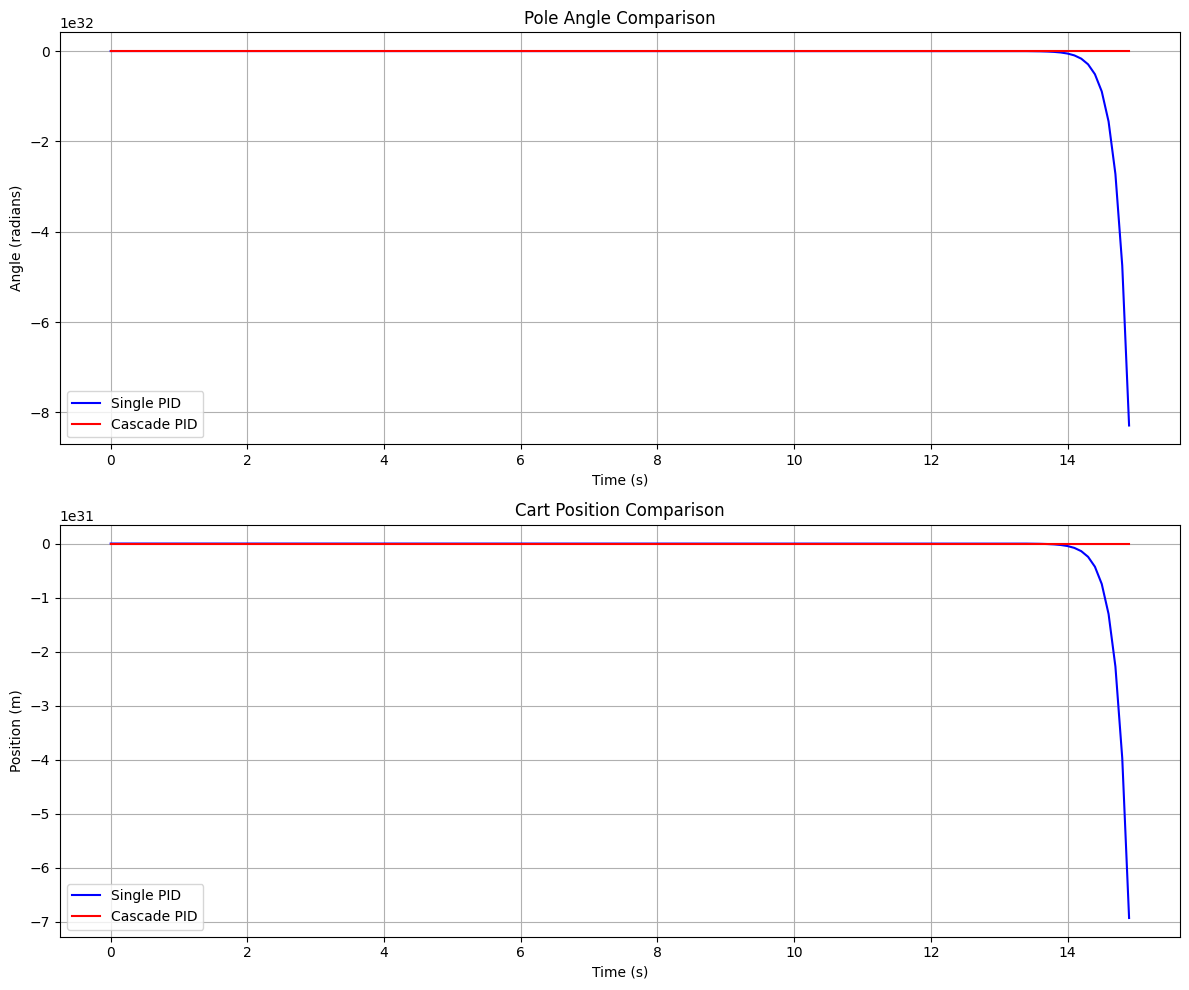

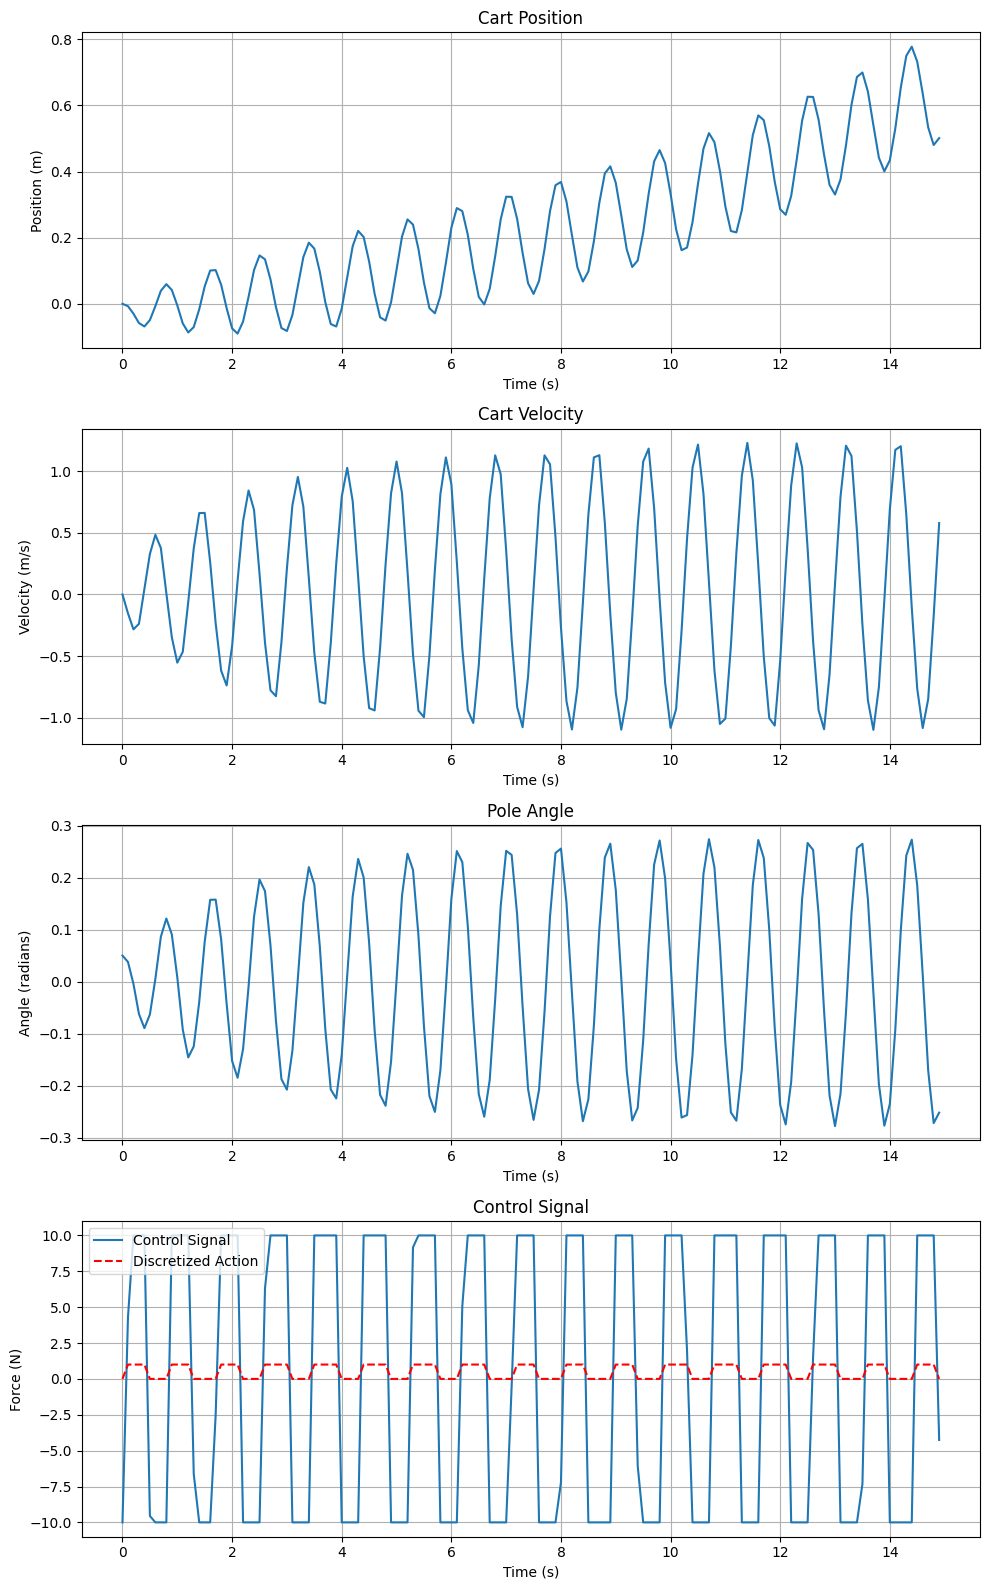

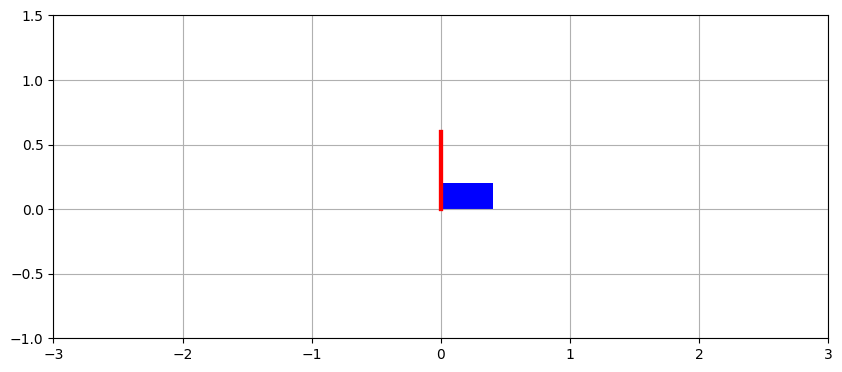

Saving animation to: c:\Users\james\OneDrive\Desktop\Folders\CSE 2025


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import solve_ivp

# Physical parameters of the cart-pole system
M = 0.5    # Cart mass (kg)
m = 0.2    # Pendulum mass (kg)
b = 0.1    # Cart friction coefficient (N/m/s)
I = 0.006  # Pendulum moment of inertia (kg⋅m²)
g = 9.81   # Gravitational acceleration (m/s²)
l = 0.3    # Length to pendulum center of mass (m)
Ts = 1/10  # Sampling time (s)

# State space model matrices
A_22 = (-(I+m*l**2)*b)/(I*(M+m)+M*m*l**2)
A_23 = (m**2 * g * l**2)/ (I*(M+m) + M*m* l**2)
A_42 = (-m*l*b)/(I*(M+m) + M*m* l**2)
A_43 = ((m*g*l)*(M+m))/(I*(M+m) + M*m* l**2)
B_2 = (I + m*l**2)/(I*(M+m) + M*m*l**2)
B_4 = (m*l)/(I*(M+m) + M*m*l**2)

# State space matrices
A = np.array([
    [0, 1, 0, 0],
    [0, A_22, A_23, 0],
    [0, 0, 0, 1],
    [0, A_42, A_43, 0]
])

B = np.array([
    [0],
    [B_2],
    [0],
    [B_4]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

D = np.array([
    [0],
    [0]
])

class PIDController:
    def __init__(self, kp, ki, kd, output_limits=None):
        self.kp = kp  # Proportional gain
        self.ki = ki  # Integral gain
        self.kd = kd  # Derivative gain
        self.prev_error = 0
        self.integral = 0
        self.output_limits = output_limits  # Tuple (min, max) or None
    
    def update(self, error, dt=Ts):  # Using the defined sampling time
        # Calculate the integral term with anti-windup
        self.integral += error * dt
        
        # Apply anti-windup if limits are provided
        if self.output_limits:
            self.integral = np.clip(self.integral, -5.0, 5.0)
        
        # Calculate the derivative term
        derivative = (error - self.prev_error) / dt
        
        # Calculate the control output
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        
        # Apply output limits if provided
        if self.output_limits:
            output = np.clip(output, self.output_limits[0], self.output_limits[1])
        
        # Update previous error for next iteration
        self.prev_error = error
        
        return output

class CascadePIDController:
    def __init__(self, angle_kp, angle_ki, angle_kd, position_kp, position_ki, position_kd, force_limits=(-10, 10)):
        # Outer loop (angle) controller
        self.angle_pid = PIDController(angle_kp, angle_ki, angle_kd, output_limits=(-2, 2))
        
        # Inner loop (position) controller
        self.position_pid = PIDController(position_kp, position_ki, position_kd, output_limits=force_limits)
        
        # Target angle (usually 0 for upright position)
        self.target_angle = 0
        
        # Force limits
        self.force_limits = force_limits
    
    def update(self, x, theta, dt=Ts):
        # Outer loop: Calculate desired cart position based on pole angle
        angle_error = self.target_angle - theta
        desired_position = self.angle_pid.update(angle_error, dt)
        
        # Inner loop: Calculate force based on desired position
        position_error = desired_position - x
        control_force = self.position_pid.update(position_error, dt)
        
        # Apply force limits
        control_force = np.clip(control_force, self.force_limits[0], self.force_limits[1])
        
        return control_force

def cartpole_dynamics(t, state, u):
    """
    Custom cart-pole dynamics based on the provided parameters.
    state = [x, x_dot, theta, theta_dot]
    u = control input (force applied to cart)
    """
    # Calculate state derivatives using the state space model
    state_dot = A @ state + B @ np.array([u])
    
    return state_dot.flatten()

def run_custom_cartpole_with_cascade_pid(angle_kp=15.0, angle_ki=0.1, angle_kd=40.0,
                                        position_kp=10.0, position_ki=0.2, position_kd=5.0,
                                        max_time=15.0):
    """Run a simulation of the custom cart-pole system with a cascade PID controller."""
    # Initialize cascade PID controller
    cascade_pid = CascadePIDController(
        angle_kp=angle_kp, angle_ki=angle_ki, angle_kd=angle_kd,
        position_kp=position_kp, position_ki=position_ki, position_kd=position_kd
    )
    
    # Initial state: [x, x_dot, theta, theta_dot]
    # Starting with a small angle to make it interesting
    initial_state = np.array([0.0, 0.0, 0.05, 0.0])
    
    # Time points
    t_span = (0, max_time)
    t_eval = np.arange(0, max_time, Ts)
    
    # Function for the ODE solver that incorporates the cascade PID controller
    def system_with_control(t, state):
        # Extract cart position and pole angle from state
        x = state[0]
        theta = state[2]
        
        # Get control signal from cascade PID
        control_signal = cascade_pid.update(x, theta, Ts)
        
        # Return the system dynamics
        return cartpole_dynamics(t, state, control_signal)
    
    # Solve the ODE
    solution = solve_ivp(
        system_with_control,
        t_span,
        initial_state,
        method='RK45',
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    
    # Calculate control signals for each time point after the simulation
    times = solution.t
    states = solution.y
    control_signals = []
    actions = []
    
    # Reset cascade PID controller for consistent calculation
    cascade_pid = CascadePIDController(
        angle_kp=angle_kp, angle_ki=angle_ki, angle_kd=angle_kd,
        position_kp=position_kp, position_ki=position_ki, position_kd=position_kd
    )
    
    for i in range(len(times)):
        x = states[0, i]
        theta = states[2, i]
        control_signal = cascade_pid.update(x, theta, Ts)
        control_signals.append(control_signal)
        actions.append(1 if control_signal > 0 else 0)
    
    return times, states, np.array(control_signals), np.array(actions)

def visualize_custom_simulation(times, states, control_signals, actions):
    """Visualize the results of the custom cart-pole simulation."""
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))
    
    # Plot cart position
    axs[0].plot(times, states[0, :])
    axs[0].set_title('Cart Position')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Position (m)')
    axs[0].grid(True)
    
    # Plot cart velocity
    axs[1].plot(times, states[1, :])
    axs[1].set_title('Cart Velocity')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[1].grid(True)
    
    # Plot pole angle (in radians)
    axs[2].plot(times, states[2, :])
    axs[2].set_title('Pole Angle')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Angle (radians)')
    axs[2].grid(True)
    
    # Plot control signal
    axs[3].plot(times, control_signals, label='Control Signal')
    # Plot discretized actions
    axs[3].plot(times, actions, 'r--', label='Discretized Action')
    axs[3].set_title('Control Signal')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Force (N)')
    axs[3].legend()
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

def animate_custom_cartpole(times, states):
    """Create an animation of the cart-pole system."""
    # Cart and pendulum dimensions
    cart_width = 0.4
    cart_height = 0.2
    pole_length = l * 2  # Multiplying by 2 for visibility
    
    # Figure setup
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, xlim=(-3, 3), ylim=(-1, 1.5))
    ax.set_aspect('equal')
    ax.grid()
    
    # Create objects
    cart = plt.Rectangle((0, 0), cart_width, cart_height, fc='b')
    pole = plt.Line2D([0, 0], [0, pole_length], lw=3, c='r')
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    def init():
        # Initialize animation
        ax.add_patch(cart)
        ax.add_line(pole)
        time_text.set_text('')
        return cart, pole, time_text
    
    def animate(i):
        # Animation update function
        x = states[0, i]
        theta = states[2, i]
        
        # Update cart position
        cart.set_xy([x - cart_width/2, -cart_height/2])
        
        # Update pole position
        pole.set_xdata([x, x + pole_length * np.sin(theta)])
        pole.set_ydata([0, pole_length * np.cos(theta)])
        
        # Update time
        time_text.set_text(f'Time: {times[i]:.2f}s')
        
        return cart, pole, time_text
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(times), interval=Ts*1000,
                                   blit=True)
    
    return anim

# Function to compare single PID vs cascade PID
def compare_controllers(max_time=15.0):
    # Run single PID simulation
    kp = 15.0
    ki = 0.1
    kd = 40.0
    
    print("Running Single PID Controller...")
    print(f"PID parameters: Kp={kp}, Ki={ki}, Kd={kd}")
    
    # Create PID controller
    pid = PIDController(kp, ki, kd)
    
    # Initial state: [x, x_dot, theta, theta_dot]
    initial_state = np.array([0.0, 0.0, 0.05, 0.0])
    
    # Time points
    t_span = (0, max_time)
    t_eval = np.arange(0, max_time, Ts)
    
    # Function for the ODE solver that incorporates the PID controller
    def system_with_pid(t, state):
        # Extract pole angle from state
        theta = state[2]
        
        # Calculate error (we want theta = 0, upright position)
        error = -theta  # Negative because we want to counteract the angle
        
        # Get control signal from PID
        control_signal = pid.update(error, Ts)
        
        # Limit the control force
        control_signal = np.clip(control_signal, -10, 10)
        
        # Return the system dynamics
        return cartpole_dynamics(t, state, control_signal)
    
    # Solve the ODE for single PID
    pid_solution = solve_ivp(
        system_with_pid,
        t_span,
        initial_state,
        method='RK45',
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )
    
    pid_times = pid_solution.t
    pid_states = pid_solution.y
    
    # Run cascade PID simulation
    angle_kp = 15.0
    angle_ki = 0.1
    angle_kd = 20.0
    position_kp = 10.0
    position_ki = 0.1
    position_kd = 5.0
    
    print("\nRunning Cascade PID Controller...")
    print(f"Angle PID: Kp={angle_kp}, Ki={angle_ki}, Kd={angle_kd}")
    print(f"Position PID: Kp={position_kp}, Ki={position_ki}, Kd={position_kd}")
    
    cascade_times, cascade_states, cascade_controls, _ = run_custom_cartpole_with_cascade_pid(
        angle_kp=angle_kp, angle_ki=angle_ki, angle_kd=angle_kd,
        position_kp=position_kp, position_ki=position_ki, position_kd=position_kd,
        max_time=max_time
    )
    
    # Compare results
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot pole angle comparison
    axs[0].plot(pid_times, pid_states[2, :], 'b-', label='Single PID')
    axs[0].plot(cascade_times, cascade_states[2, :], 'r-', label='Cascade PID')
    axs[0].set_title('Pole Angle Comparison')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Angle (radians)')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot cart position comparison
    axs[1].plot(pid_times, pid_states[0, :], 'b-', label='Single PID')
    axs[1].plot(cascade_times, cascade_states[0, :], 'r-', label='Cascade PID')
    axs[1].set_title('Cart Position Comparison')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Position (m)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return pid_states, cascade_states

# Main execution
if __name__ == "__main__":
    # Set cascade PID parameters
    angle_kp = 15.0    # Angle proportional gain
    angle_ki = 0.1     # Angle integral gain
    angle_kd = 20.0    # Angle derivative gain
    position_kp = 5.0  # Position proportional gain
    position_ki = 0.1   # Position integral gain
    position_kd = 5.0   # Position derivative gain
    
    print("Running Custom Cart Pole with Cascade PID controller...")
    print(f"Angle PID: Kp={angle_kp}, Ki={angle_ki}, Kd={angle_kd}")
    print(f"Position PID: Kp={position_kp}, Ki={position_ki}, Kd={position_kd}")
    
    # Choose whether to run just cascade PID or comparison
    run_comparison = True
    
    if run_comparison:
        # Run comparison between single PID and cascade PID
        pid_states, cascade_states = compare_controllers(max_time=15.0)
        
        # Calculate error metrics
        pid_angle_mse = np.mean(pid_states[2, :]**2)
        cascade_angle_mse = np.mean(cascade_states[2, :]**2)
        
        # print("\nPerformance Comparison:")
        # print(f"Single PID Angle MSE: {pid_angle_mse:.6f}")
        # print(f"Cascade PID Angle MSE: {cascade_angle_mse:.6f}")
        # print(f"Improvement: {(pid_angle_mse - cascade_angle_mse) / pid_angle_mse * 100:.2f}%")
    else:
        # Run just cascade PID
        times, states, control_signals, actions = run_custom_cartpole_with_cascade_pid(
            angle_kp=angle_kp, angle_ki=angle_ki, angle_kd=angle_kd,
            position_kp=position_kp, position_ki=position_ki, position_kd=position_kd,
            max_time=15.0
        )
        
    # Visualize results
    visualize_custom_simulation(times, states, control_signals, actions)
    
    # Create and show animation
    anim = animate_custom_cartpole(times, states)
    plt.show()
    
    # Save animation
    from matplotlib.animation import PillowWriter
    import os
    print("Saving animation to:", os.getcwd())
    anim.save('CascadePID.gif', writer=PillowWriter(fps=10))